In [9]:
%cd '/home/danbi/userdata/DANBI/gugakwon/Yeominrak'
%load_ext autoreload
%autoreload 2
from music21 import converter, stream, note as m21_note 
from yeominrak_processing import Gnote, Part, Tokenizer
import random as random
from typing import List, Set, Dict, Tuple
import music21 as m21

/home/danbi/userdata/DANBI/gugakwon/Yeominrak
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
def get_part_templates(part):
  part_templates = []
  for measure in part:
    note_list = []
    # for note in measure:
    #   note.pitch = 0
    # note_temp = [[note.pitch, note.duration, note.measure_offset, note.dynamic] for note in measure]
    note_temp = [[0, note.duration, note.measure_offset, note.dynamic] for note in measure]
    if note_temp not in part_templates and len(note_temp) > 0:
      part_templates.append(note_temp)
  return part_templates

class Augmentation:
    def __init__(self, xml_path='/home/danbi/userdata/DANBI/gugakwon/Yeominrak/0_edited.musicxml') -> None:
        self.xml_path = xml_path
        self.score = converter.parse(xml_path)
        self.parts = [Part(part, i) for i, part in enumerate(self.score.parts)]
        self._get_part_templates()
        self.tokenizer = Tokenizer(self.parts)
        self.vocab = self.tokenizer.vocab
        self.vocab_size_dict = self.tokenizer.vocab_size_dict

    def _get_part_templates(self):
        self.first_part_temp = get_part_templates([measure for measure in self.parts[0].measures])
        self.second_part_temp = get_part_templates([measure for measure in self.parts[1].measures])
        self.third_part_temp = get_part_templates([measure for part in self.parts[2:6] for measure in part.measures ])
        self.final_part_temp = get_part_templates([measure for measure in self.parts[-1].measures])
        # self.score = converter.parse(self.xml_path)
        # self.parts = [Part(part, i) for i, part in enumerate(self.score.parts)]
        
dataset = Augmentation()

In [50]:
xml_path='/home/danbi/userdata/DANBI/gugakwon/Yeominrak/0_edited.musicxml'
score = converter.parse(xml_path)
i = 0
part = Part(score.parts[0], 0)
  

In [51]:
def apply_tie(notes, part_idx) :
    tied_notes = []
    for note in notes:
        if note.tie is not None:
            if note.tie.type == 'start':
                tied_notes.append(Gnote(note, part_idx))
            elif note.tie.type == 'continue':
                tied_notes[-1] +=  note
            elif note.tie.type == 'stop':
                tied_notes[-1] += note
            else:
                raise ValueError(f'Unknown tie type: {note.tie.type}')
        else:
            tied_notes.append(Gnote(note, part_idx))
        
    return tied_notes


In [52]:
final_part = [measure for measure in dataset.parts[-1].measures]

In [68]:
final_part[0]

[Gnote: 51.0, 1.0, 0.0, strong,
 Gnote: 51.0, 2.0, 1.0, weak,
 Gnote: 51.0, 1.0, 3.0, middle,
 Gnote: 34.0, 0.5, 4.0, weak,
 Gnote: 51.0, 0.5, 4.5, weak,
 Gnote: 51.0, 1.0, 5.0, strong,
 Gnote: 48.0, 1.0, 6.0, weak,
 Gnote: 48.0, 1.0, 7.0, middle,
 Gnote: 46.0, 1.0, 8.0, weak,
 Gnote: 44.0, 1.0, 9.0, weak]

In [117]:
import random as random
from collections import Counter

def modify_single_pitch(data, ratio=0.1): # 일정한 비율로 피치 바꾸기, # Gnote인 경우!
  modified_list = []
  for note in data:
      if random.random() < ratio:
          pitch = random.choice(dataset.vocab['pitch'][3:])
          note.pitch = pitch
          print("pitch_changed!")
  return data

def modify_pitch(data, ratio=0.1): # 음.. 이미 gnote가 아닌 경우!
  modified_list = []
  isinstance(data, list)
  most_common_note = Counter([note[0] for note in data]).most_common(1)[0][0]
  # print('most_common_note', most_common_note)
  most_common_pitch_idx = dataset.tokenizer.tok2idx['pitch'][most_common_note]
  # print('most_common_pitch_idx', most_common_pitch_idx)
  # modify_single_pitch=0
  for note in data:
    # print(note)
    if random.random() < ratio:
      if most_common_pitch_idx not in [0,1,2]:
        # print(dataset.vocab['pitch'][most_common_pitch_idx-2: most_common_pitch_idx+2])
        pitch = random.choice(dataset.vocab['pitch'][most_common_pitch_idx-2: most_common_pitch_idx+2])
        # print(pitch)
        note[0] = pitch
      # print("pitch_changed!")    
  return data

# a = modify_pitch(final_part[0])
# a[:20]

In [81]:
dataset.tokenizer.tok2idx['pitch']['pad']

0

In [54]:
def omit_notes(data, convert_num = 2):
  print(data[0])
  if isinstance(data[0], Gnote):
  # try:
    note_list = [[note.pitch, note.duration, note.measure_offset, note.dynamic] for note in data]
  # except:
  else:
    note_list = data
    # sum_duration = sum([note[1] for note in note_list])
  for _ in range(convert_num):  
    num_valid_notes = len(note_list) - 2
    if num_valid_notes < 2:
      break
    converted_note_idx = random.randint(1, num_valid_notes)
    # print(converted_note_idx)
    if note_list[converted_note_idx][1] % 0.5 != 0.0 or note_list[converted_note_idx-1][1] % 0.5 != 0.0:
      continue
    note_list[converted_note_idx-1][1] += note_list[converted_note_idx][1]
    note_list.pop(converted_note_idx )
    print("omited!")
  return note_list

In [55]:
valid_measure_idx = [i for i in range(93, 105)]
data_set = [measure for i, measure in enumerate(final_part) if i not in valid_measure_idx]
len(final_part), len(data_set)

(160, 148)

In [61]:
from yeominrak_processing import AlignedScore, SamplingScore, pack_collate, ShiftedAlignedScore
from decode import MidiDecoder
from torch.utils.data import Dataset, DataLoader
val_dataset = ShiftedAlignedScore(is_valid= True)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=pack_collate, drop_last=True)

decoder = MidiDecoder(valid_loader)

In [65]:
data = final_part[0]
# part_idx = 6
def make_new_melody_from_final_melodies(data):
  # ======= part_idx = 6 ========
  part_6 = data.copy()
  part_6 = modify_single_pitch(data, ratio=0.1)
  part_6 = omit_notes(part_6, convert_num=1)
  
  # ======= part_idx = 5~2 ========
  third_pair_dic = {0.0: 0.0, 1.0: 1.0, 2.0: 2.0, 3.0: 3.0, 4.0:4.0, 5.0: 4.0,\
  6.0:5.0, 7.0:6.0, 8.0:7.0, 9.0:8.0}
  
  random_idx = random.randint(0, len(dataset.third_part_temp)-1)
  random_part_temp_5 = dataset.third_part_temp[random_idx]
  part_5 = []
  org_note = data[0]
  for note in random_part_temp_5:
    if float(note[2]) in third_pair_dic.keys():  
      org_offset = third_pair_dic[float(note[2])]
      for o_note in data:
        if o_note.measure_offset == org_offset:
          org_note = o_note
          break
      # org_notes = [note for note in data if note.measure_offset == org_offset]
      # if len(org_notes) > 0:
      #   org_note = org_notes[0]
      # for org_note in data:
      #   if org_note.measure_offset == org_offset:
      #     break
          # note[0] = org_note.pitch
          # if note[0] == 0:
            # note[0] = random.choice(dataset.vocab['pitch'][3:])
            # note[0] = org_note.pitch
    # else:
      # note[0] = random.choice(dataset.vocab['pitch'][3:])
    note[0] = org_note.pitch
    part_5.append(note)
  part_4 = part_5.copy()
  # print(part_4)
  part_4 = omit_notes(modify_pitch(part_4, ratio=0.1), convert_num=1)
  part_3 = omit_notes(modify_pitch(part_4, ratio=0.1), convert_num=1)
  part_2 = modify_pitch(part_3, ratio=0.1)
  
  # ======= part_idx = 1 ========
  second_pair_dic = {0.0: 0.0, 1.0: 1.0, 2.0: 2.0, 3.0: 3.0, 4.0:4.0, 5.0: 4.0, \
                    6.0: 0.0, 7.0: 1.0}
  random_part_temp_1 = dataset.second_part_temp[random.randint(0, len(dataset.second_part_temp)-1)]  
  part_1 = []
  for note in random_part_temp_1:
    if float(note[2]) in third_pair_dic.keys():  
      org_offset = third_pair_dic[float(note[2])]
      for org_note in data:
        if org_note.measure_offset == org_offset:
          note[0] = org_note.pitch
          if note[0] == 0:
            note[0] = random.choice(dataset.vocab['pitch'][3:])
    else:
      note[0] = random.choice(dataset.vocab['pitch'][3:])
    part_1.append(note)
  
  # ======= part_idx = 0 ========
  first_pair_dic = {0.0: 0.0, 2.5: 5.0}
  random_part_temp_0 = dataset.first_part_temp[random.randint(0, len(dataset.first_part_temp)-1)]
  part_0 = []
  for note in random_part_temp_0:
    if float(note[2]) in third_pair_dic.keys():  
      org_offset = third_pair_dic[float(note[2])]
      for org_note in data:
        if org_note.measure_offset == org_offset:
          note[0] = org_note.pitch
          if note[0] == 0:
            note[0] = random.choice(dataset.vocab['pitch'][3:])
    else:
      note[0] = random.choice(dataset.vocab['pitch'][3:])
    part_0.append(note)
  last_part = [[note.pitch, note.duration, note.measure_offset, note.dynamic] for note in data]
  # return [last_part, part_6, part_5, part_4, part_3, part_2, part_1, part_0]
  return [part_0, part_1, part_2, part_3, part_4, part_5, part_6, last_part]




pitch_changed!
Gnote: 51.0, 1.0, 0.0, strong
omited!
pitch_changed!
[51.0, 3.0, 0.0, 'strong']
omited!
pitch_changed!
[51.0, 6.0, 0.0, 'strong']
pitch_changed!


pitch_changed!
Gnote: 44.0, 1.0, 0.0, strong
omited!
[44.0, 2.0, 0.0, 'strong']
omited!
[44.0, 2.0, 0.0, 'strong']
omited!


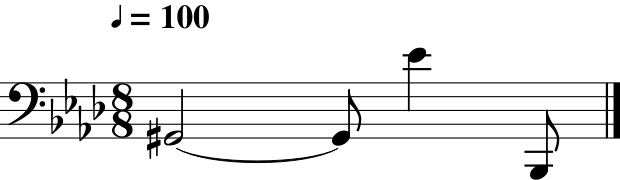

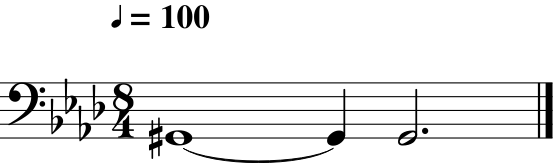

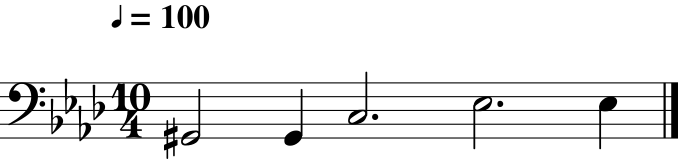

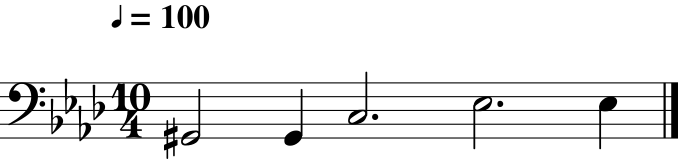

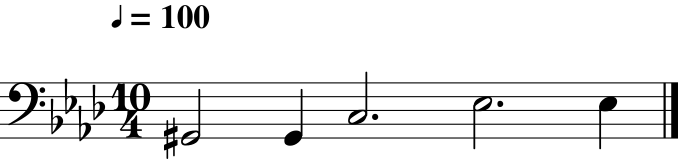

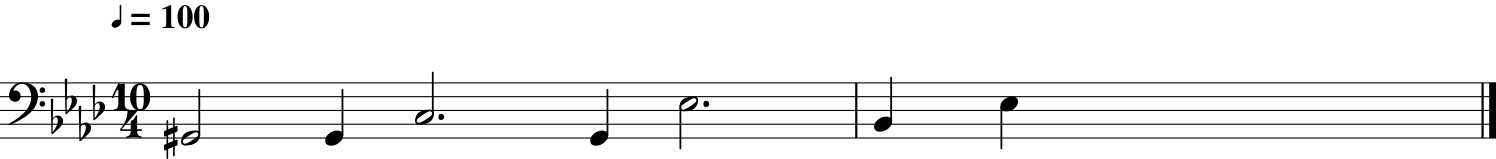

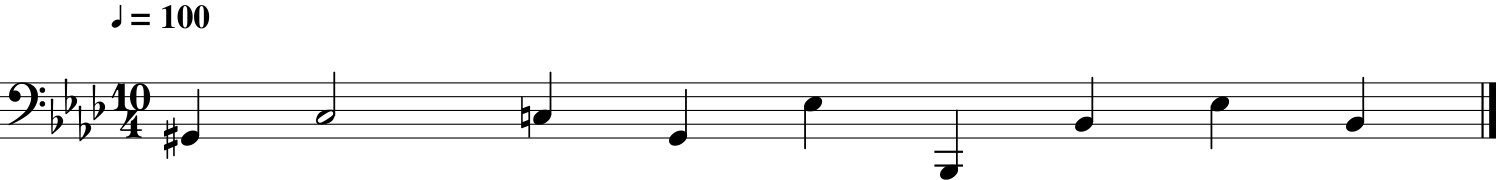

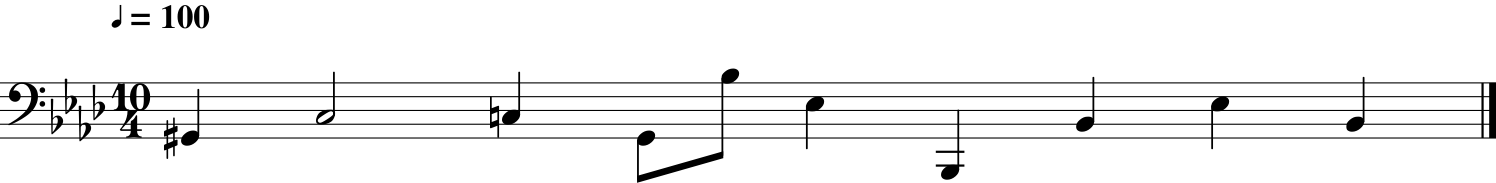

In [119]:
a = make_new_melody_from_final_melodies(data)
pair_set = []
for idx in range(8):
  new_part = [[idx]+note for note in a[idx]]
  decoder(new_part).show()

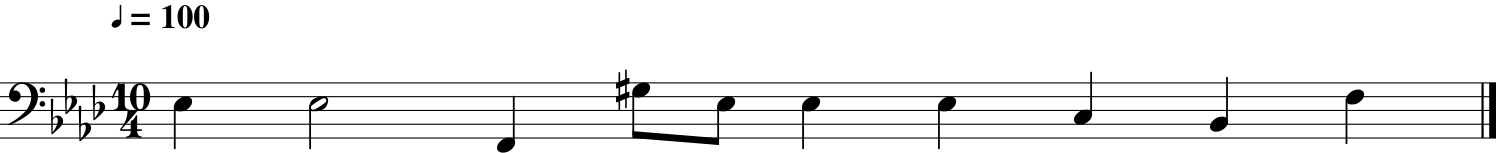

In [ ]:
pair_dic = {0.0: 0.0, 1.0: 1.0, 2.0: 2.0, 3.0: 3.0, 4.0:4.0, 5.0: 4.0,\
  6.0:5.0, 7.0:6.0, 8.0:7.0, 9.0:8.0}

In [429]:

  if part_idx == 0:
    part_temp = dataset.first_part_temp
  elif part_idx == 1:
    part_temp = dataset.second_part_temp
  elif part_idx in [2,3,4,5]:
    part_temp = dataset.third_part_temp
  elif part_idx in [6,7]:
    part_temp = dataset.final_part_temp

0.6000000000000001

In [80]:
part_templates = []
for measure in third_part:
  note_list = []
  for note in measure:
    note.pitch = 0
  note_temp = [[note.pitch, note.duration, note.measure_offset] for note in measure]
  if note_temp not in part_templates:
    part_templates.append(note_temp)
len(third_part), len(part_templates)

(500, 39)

In [93]:
first_part_tem = third_part)
first_part_tem[8]


[[0, 3.0, 0.0], [0, 2.0, 3.0], [0, 2.0, 6.0], [0, 1.0, 8.0], [0, 1.0, 9.0]]

In [26]:
# There are note's pitch, duration, offset(from start), measure_number(+1), measure_offset.
final_part[0]

[Gnote: 51.0, 1.0, 0.0, strong,
 Gnote: 51.0, 2.0, 1.0, weak,
 Gnote: 51.0, 1.0, 3.0, middle,
 Gnote: 46.0, 0.5, 4.0, weak,
 Gnote: 51.0, 0.5, 4.5, weak,
 Gnote: 51.0, 1.0, 5.0, strong,
 Gnote: 51.0, 1.0, 6.0, weak,
 Gnote: 48.0, 1.0, 7.0, middle,
 Gnote: 46.0, 1.0, 8.0, weak,
 Gnote: 53.0, 1.0, 9.0, weak]